# Machine Learning for Loan Default Prediction

In this notebook, we apply several machine learning algorithms to identify customers that will default on their loan. We are going to use five machine learning models suitable for this classification tasks:

- logistic regression,
- random forest,
- gradient boosting,
- artificial neural network,
- stacked classifier (4 models above as base learners and random forest as meta model).

## Dataset

The dataset is contained in the excel file ```data_loan_default.xlsx```. It contains data for 8929 loans issued between January 2007 and September 2017. There are 20 independent variables and one dependent variable. The dependent variable, ```charged_off```, takes value 1 if a customer defaults on his loan and 0 otherwise. Let's first import the relevant libraries and the dataset.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, \
    precision_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from hyperopt import hp, tpe, fmin, Trials
from sklearn.svm import SVC

# Import data
df = pd.read_excel('data_loan_default.xlsx')

df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,issue_d,purpose,dti,earliest_cr_line,...,pub_rec,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,5675,36,189.56,2.0,RENT,Source Verified,2014-12-01,car,15.55,1992,...,0,15.0,15,Individual,0.0,0.0,4.698979,697.0,3.464936,0
1,7000,36,242.63,1.0,RENT,Source Verified,2014-12-01,car,6.78,2002,...,0,69.2,5,Individual,0.0,0.0,4.301052,717.0,3.431364,0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,2014-12-01,car,10.65,1997,...,0,12.6,35,Individual,2.0,0.0,4.681250,742.0,3.765520,0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,2014-12-01,car,21.74,1996,...,0,23.7,22,Individual,4.0,0.0,4.875067,707.0,3.424555,0
4,1500,36,46.31,2.0,OWN,Not Verified,2014-12-01,car,12.17,1997,...,0,46.5,13,Individual,2.0,0.0,4.812920,712.0,4.448211,0


Let's check the proportion of loans in each class.

In [2]:
df['charged_off'].value_counts(normalize=True)

0    0.852055
1    0.147945
Name: charged_off, dtype: float64

We notice that our dataset is imbalanced. Therefore, we will need to take that into account when training the models.

## Data preprocessing

### Feature engineering

First, we notice that the ```earliest_cr_line``` variable provides the date of the earliest credit line of the customer. However, this does not provide any useful information because the loans are issued at different dates. Therefore, we transform this variable to obtain the number of years between the earliest credit line and the loan issue date. 

In [3]:
# Compute years since earliest credit line
df['yr_since_earliest_cr_line'] = pd.DatetimeIndex(df['issue_d']).year - df['earliest_cr_line']
df = df.drop('earliest_cr_line', axis=1)

We also notice that the ```purpose``` feature always contains the same value. We remove this feature as it provides no information. Similarly, the ```application_type``` contains the same value for almost 100% of the loans, therefore, we remove the feature. Finally, we want our model to predict default for future issue dates. Therefore, we also remove the ```issue_d``` feature.

In [4]:
# Drop columns
df = df.drop(['purpose', 'issue_d', 'application_type'], axis=1)

### Missing values

Let's compute the fraction of missing values per feature.

In [5]:
df.isnull().sum() / len(df)

loan_amnt                    0.000000
term                         0.000000
installment                  0.000000
emp_length                   0.047598
home_ownership               0.000000
verification_status          0.000000
dti                          0.000000
open_acc                     0.000000
pub_rec                      0.000000
revol_util                   0.001568
total_acc                    0.000000
mort_acc                     0.196663
pub_rec_bankruptcies         0.001904
log_annual_inc               0.000000
fico_score                   0.000000
log_revol_bal                0.000000
charged_off                  0.000000
yr_since_earliest_cr_line    0.000000
dtype: float64

Four of our features contain missing values. The ```mort_acc``` feature contains almost 20% of missing values. Because is this a relatively high proportion, we decide to remove this feature. Both ```emp_length``` and ```revol_util``` contain continuous numeric values. For those features, we replace the missing values by their respective median. For ```pub_rec_bankruptcies```, we set the missing values to zero as is it the value occurring most frequently.

In [6]:
# Impute missing values
df = df.drop('mort_acc', axis=1)
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].median())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

### Categorical variables

We also have two categorical variables, namely ```home_ownership``` and ```verification_status```. Because our machine learning algorithms do not handle categorical variables directly, we one-hot encode them. Note that we drop one of the created dummy variables to reduce multicollinearity. 

In [7]:
# One-hot encoding
df = pd.get_dummies(df, columns=['home_ownership', 'verification_status'], drop_first=True)

### Dataset split

We split the data set into a training and a test set. Because our dataset is relatively small, we do not use a validation set (cross-validation is used for model selection). We decide to keep 85% of the dataset for training and the remaining 15% is held out for testing the model. This split allows to keep a significant proportion of the dataset for training. The split is performed such that the percentage of data for each class remains the same (i.e., 85% for non-defaulting loans and 15% for defaulting loans) in each set.

Note that we do not consider the time dependency when splitting the dataset. Another method would have been to create the test set with the 15% most recent loans. This simulates the real life environment where we create a model based on past and current information to predict the future. 

In [8]:
# Separate input and output
y = df['charged_off'].values
X = df.drop('charged_off', axis=1).values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

### Feature scaling

Finally, we scale the features such that their respective mean is zero and their respective standard deviation is one. Mathematically, the transformation is performed according to

\begin{equation}
    z_{i, j} = \frac{x_{i, j} - \mu_{j}}{\sigma_{j}},  \,\,\, i = 1,2,...,N, \,\,\, j = 1, 2,..., p
\end{equation}    

where $N$ is the number of loans, $p$ is the number of features, $z_{i, j}$ is the normalized value of feature $j$ for loan $i$, $x_{i, j}$ is the value of feature $j$ for loan $i$, $\mu_{j}$ is the mean of feature $j$ and $\sigma_j$ is the standard deviation of feature $j$.

Note that all the models we use do not necessarily require feature scaling. For example, tree-based methods such as random forest or gradient boosting are not affected by monotonic transformations of the data. 

In [9]:
# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Methods

### Optimization metric

The choice of the optimization metric is critical here. Accuracy does not seem to be a relevant choice because we can obtain an 85% accuracy with a useless model that classifies every loan as non-defaulting. Also, it is important to understand the needs of the bank. The cost of misclassifying a non-defaulting loan is lower than the cost of misclassifying a defaulting loan. For this reason, recall for the default class seems to be a relevant optimization metric. Again, 100% recall is easily achievable by classifying all the loans as defaulting. However, the model would be useless. Here, we decide to use the macro recall (i.e., average recall per class) as the optimization metric. If the results are not satisfactory, it is still possible to modify the class weights or the threshold used to determine the class.

### Cross-validation

With all the learning algorithms, we use cross-validation to perform hyperparameter optimization. In order to preserve the class weightings, we use stratified K-fold cross-validation (with K=5).

In [10]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds)

### Class imbalance mitigation

As previously discussed, our dataset is imbalanced (15% of data in the positive class). To prevent the learners from exhibiting bias towards the majority class, we need to mitigate class imbalance. Here, we decide to balance the class weights at the time of fitting the models. Balanced class weights are computed as

\begin{align}
    w_0 &= \frac{1}{n_0} \frac{(n_0 + n_1)}{2} \\
    w_1 &= \frac{1}{n_1} \frac{(n_0 + n_1)}{2}
\end{align}

where $w_i$ is the weight for class $i$ and $n_i$ is the number of samples for class $i$. Herein, we will use those class weights directly. However, it also would be possible to optimize them with cross-validation. 

In [11]:
# Compute balanced class weights
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {0:weights[0], 1:weights[1]}

print('Balanced weights are given by: ' + str(weights))

Balanced weights are given by: {0: 0.586838849365914, 1: 3.3788958147818344}


Above we computed the class weights using the ```Scikit-learn``` package. Let's confirm that we obtain the same weights with our formulas. 

In [12]:
# Positive and negative class counts
pos = len(y_train[y_train == 1])
neg = len(y_train[y_train == 0])
total = neg + pos

# Compute weights
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1} 

print('Balanced weights are given by: ' + str(class_weight))

Balanced weights are given by: {0: 0.586838849365914, 1: 3.3788958147818344}


## Logistic regression

### Hyperparameter tuning

We first implement a logistic regression model. The hyperparameters of the model that we want to tune are the type of regularization and its (inverse) strength. The penalty terms, L1 or L2, are considered mutually exclusive (i.e., not in the form of an elastic net). Values considered for the inverse of the regularization strength, $C$, are in the range $[10^{-5}, 10^5]$ with values in the form $C = 10^n, n \in \mathbb{Z}$.

Because the hyperparameter space is relatively small, we use an exhaustive grid search with cross-validation to tune the hyperparameters.

Let's perform the grid search and print the best combination of hyperparameters.

In [14]:
# Instantiate model
lr = LogisticRegression(solver='liblinear', class_weight='balanced')

# Hyperparameter grids
pen = ['l1', 'l2']
C = np.logspace(-5,5,11)

# Grid search
grid_values = {'penalty': pen,'C': C}
clf_lr = GridSearchCV(lr, param_grid=grid_values, scoring='recall_macro', cv=n_folds, n_jobs=-1)

# Fit model
clf_lr.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters are :')
print(clf_lr.best_params_)

Best hyperparameters are :
{'C': 0.01, 'penalty': 'l2'}


Let's visualize the grid search results by plotting the mean cross-validation score for each combination of hyperparameters.

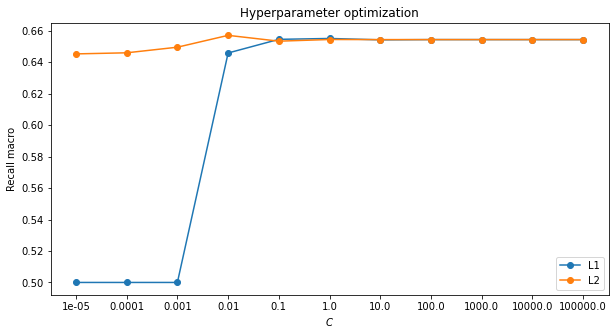

In [15]:
# Get and reshape CV scores
scores_mean = clf_lr.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(C),len(pen))

# Plot CV scores
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(scores_mean[:,0], '-o', label='L1')
ax.plot(scores_mean[:,1], '-o', label='L2')
ax.set_xlabel(r'$C$')
ax.set_ylabel('Recall macro')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start+0.5, end+0.5, 1))
ax.set_xticklabels(C)
ax.set_title('Hyperparameter optimization')
ax.legend(loc='best');

Note that, now that we now the order of magnitude of the regularization strength parameter, we could further tune it with a more granular grid. 


### Test results

Now, let's evaluate our model performance on the test set. First, we plot the confusion matrix.

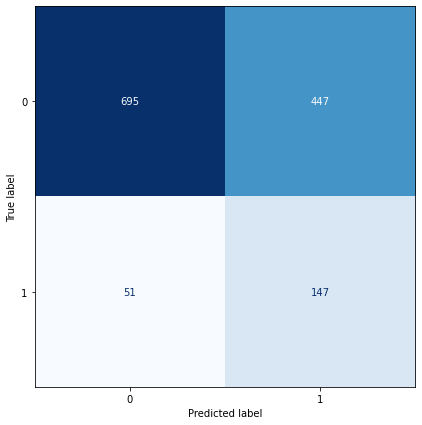

In [16]:
# Test predictions
y_pred = clf_lr.predict(X_test)

# Plot confusion matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm_lr =  confusion_matrix(y_test, y_pred, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=clf_lr.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=False);

Let's compute performance metrics on the test set and store them in a dataframe. 

In [17]:
# Get performance metrics
accuracy_lr = accuracy_score(y_test, y_pred)
recall1_lr = recall_score(y_test, y_pred)
recall0_lr = recall_score(y_test, y_pred, pos_label=0)
recall_macro_lr = recall_score(y_test, y_pred, average='macro')
precision_lr = precision_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)
roc_lr = roc_auc_score(y_test, y_pred)

# Dataframe with performance metrics
df_res = pd.DataFrame(data=[recall1_lr, recall0_lr, recall_macro_lr, accuracy_lr, precision_lr, f1_lr, roc_lr], 
                      columns=['LR'],
                      index=['Recall (1)', 'Recall (0)', 'Recall macro', 'Accuracy', 'Precision', \
                             'F1 score', 'ROC-AUC'])

df_res

,LR
Recall (1),0.742424
Recall (0),0.608581
Recall macro,0.675503
Accuracy,0.628358
Precision,0.247475
F1 score,0.371212
ROC-AUC,0.675503


Now, we plot both the Receiver Operating Characteristic (ROC) curve and the Precision-Recall (PR) curve. Note that we could have used similar curves (but with the cross-validation results instead of the test results) to identify an optimal threshold to make the classification. This would be an alternative to balancing the class weights to mitigate class imbalance. For illustration purposes, we will identify (with a red dot) the optimal point along the curves. When used during cross-validation, this optimal point can be used to retrieve an optimal threshold. Here we use the default threshold of 0.5 to make the classification (i.e., if the probability that a loan belongs to class 1 is greater than 0.5, the loan is classified in class 1).

First, let's plot the ROC curve and compute the area under the curve (displayed in the legend of the plot).

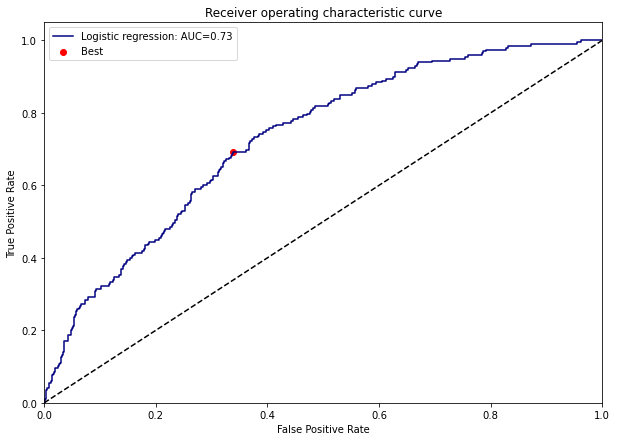

In [18]:
# Get probabilities
probs_lr = clf_lr.predict_proba(X_test)
probs_lr = probs_lr[:,1]

# Compute AUC, false positive rate and true positive rate
auc_lr = roc_auc_score(y_test, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs_lr)

# Get index of optimal threshold
gmeans_lr = np.sqrt(tpr_lr * (1-fpr_lr))
ix = np.argmax(gmeans_lr)

# Plot the ROC curve
fig_roc = plt.figure(figsize=(10, 7))
ax_roc = fig_roc.add_subplot(111)
ax_roc.plot(fpr_lr, tpr_lr, color='navy', label='Logistic regression: AUC=' + str(round(auc_lr, 2)))
ax_roc.plot([0, 1], [0, 1], color='k', linestyle='--')
ax_roc.scatter(fpr_lr[ix], tpr_lr[ix], marker='o', color='red', label='Best')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Receiver operating characteristic curve')
ax_roc.legend(loc='best');

As explained before, the optimal point on the curve allows to retrieve the optimal threshold. Here we show how to compute this optimal threshold. However, \textbf{keep in mind that an optimal threshold should be computed with cross-validation (or a validation set) but not with the test set}. We only show how to compute the threshold for illustrative purpose.

In [19]:
# Optimal threshold from ROC curve computed for illustrative purpose
print('Optimal threshold (ROC): ' + str(thresholds_lr[ix]))

Optimal threshold (ROC): 0.5286839864351477


Now, let's plot the PR curve. As before, the best point on the curve is only shown for illustrative purpose as we don't use it (or anything computed with the test set) to modify the model.

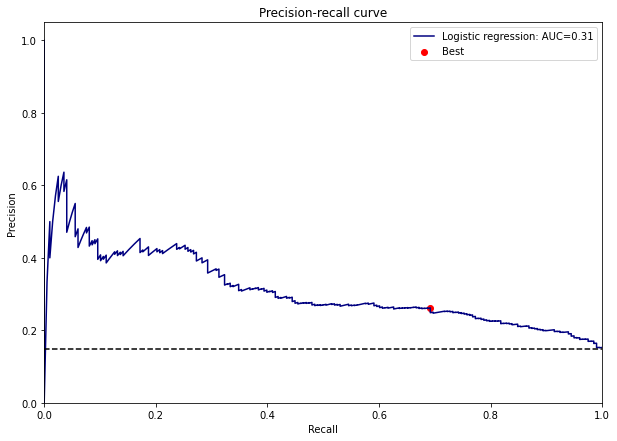

In [57]:
prec_lr, rec_lr, thresholds_pr_lr = precision_recall_curve(y_test, probs_lr)
auc_lr_pr = auc(rec_lr, prec_lr)

with np.errstate(divide='ignore', invalid='ignore'):
    fscore = (2 * prec_lr * rec_lr) / (prec_lr + rec_lr)
ix = np.nanargmax(fscore)

# Plot the PR curve
fig_pr = plt.figure(figsize=(10, 7))
ax_pr = fig_pr.add_subplot(111)
ax_pr.scatter(rec_lr[ix], prec_lr[ix], marker='o', color='red', label='Best')
ax_pr.plot(rec_lr, prec_lr, color='navy', label='Logistic regression: AUC=' + str(round(auc_lr_pr, 2)))
ax_pr.plot([0, 1], [pos/total, pos/total], color='k', linestyle='--')
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-recall curve')
ax_pr.legend(loc='best');

In [21]:
# Optimal threshold from PR curve computed for illustrative purpose
print('Optimal threshold (ROC): ' + str(thresholds_pr_lr[ix]))

Optimal threshold (ROC): 0.5286839864351477


### Feature importance

Finally, we want to identify the features that are the most important ones for the model. First, we use a permutation importance algorithm. For each feature, it computes the decrease in model score (or increase in error) resulting from shuffling the feature. Shuffling the feature values breaks the relationship with the dependent variable and with the other features. 

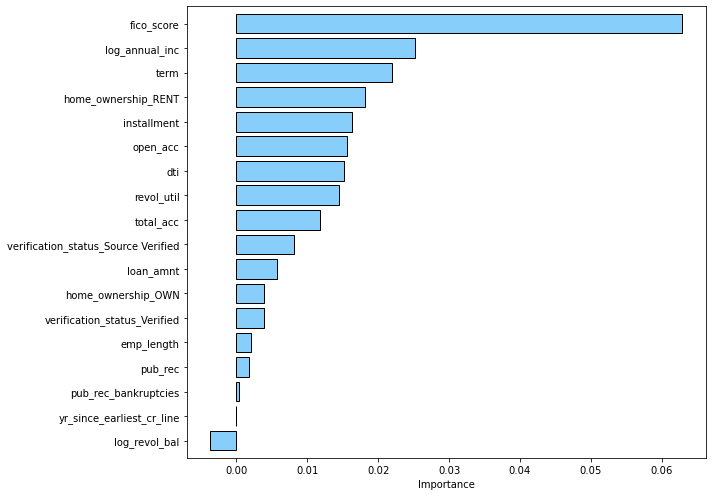

In [22]:
# Permutation feature importance
perm_imp = permutation_importance(clf_lr, X_test, y_test, n_repeats=10, scoring='recall_macro')

# Get list of features
features = np.array(list(df.drop('charged_off', axis=1).columns))

# Get index order
sorted_idx = perm_imp.importances_mean.argsort()

# Plot permutation feature importance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.barh(range(len(sorted_idx)), perm_imp.importances_mean[sorted_idx], color="lightskyblue", 
        align='center', ec='k')
ax.set_ylim(-0.7, len(sorted_idx)-0.3)
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance');
plt.tight_layout()

Now, we analyze the magnitude of the logistic regression coefficients. 

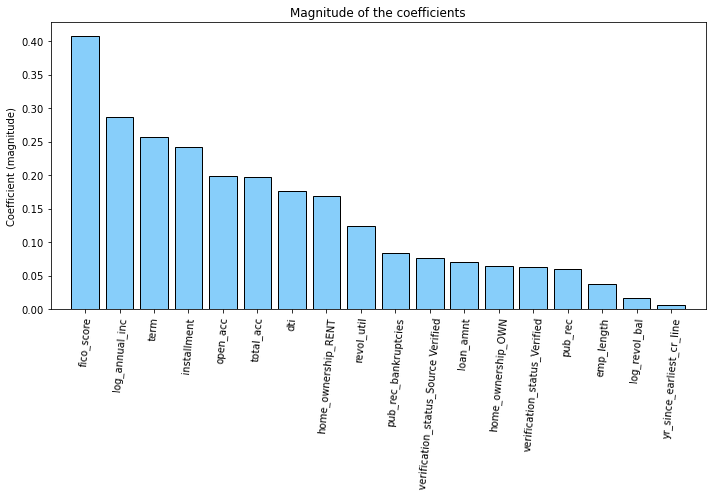

In [23]:
# Get features and coefficients from the logistic regression
coeff = np.transpose(np.abs(clf_lr.best_estimator_.coef_))
coeff = coeff[:,0]
indices = np.argsort(coeff)[::-1]

# Plot the magnitude of the coefficients
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_title("Magnitude of the coefficients")
ax.bar(range(X.shape[1]), coeff[indices], color="lightskyblue", align="center", edgecolor='k')
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(features[indices], rotation=85)
ax.set_xlim([-1, X.shape[1]])
ax.set_ylabel('Coefficient (magnitude)')
plt.tight_layout()

We should note that those coefficients are likely biased as some features are highly correlated. 

## Random forest

### Hyperparameter tuning

Now, we implement a random forest model. The best hyperparameters are also found using an exhaustive grid search with cross-validation. We want to tune the maximum depth of the trees (```max_depth```), the maximum number of features considered for a split (```max_features```) and the minimum number of samples at a leaf node (```min_samples_leaf```). 

Note that, we grow each tree using bootstrapping and compute the class weights for each tree based on the bootstrapped sample. Also note that the optimization metric is the recall. This is because using the macro recall leads to high recall scores for the negative class and low recall scores for the positive class. 

In [24]:
# Instantiate model
rfc = RandomForestClassifier(criterion='gini', n_estimators=100, bootstrap=True,
                             class_weight='balanced_subsample')

# Grid for grid search
param_grid = {'max_depth' : [2, 3, 4], 
              'max_features' : [10, 11, 12, 13, 14, None],
              'min_samples_leaf' : [20, 25, 30, 35, 40],
              }

# Instantiate grid search
clf_rf = GridSearchCV(rfc, param_grid, scoring='recall', cv=n_folds, n_jobs=-1)

# Fit model
clf_rf.fit(X_train, y_train)

# Print best hyperparameters from grid search
print('Best hyperparameters are :')
clf_rf.best_params_

Best hyperparameters are :


{'max_depth': 2, 'max_features': None, 'min_samples_leaf': 20}

With random forests, increasing the number of trees reduces the variance of the predictions. Therefore, the model performance is improved as more trees are added. However, the return of adding more trees diminishes as the number of trees increases. Also, adding more trees increases the computational cost. 

In order to evaluate if the number of trees we chose to cross-validate the model was sufficient, we can plot the out-of-bag (OOB) error as a function of the number of trees. When the OOB error is stable, it is not necessary to add more trees. Therefore, we can assess if the number of trees we used was sufficient by inspecting if the OOB error was stable at the chosen number of trees. 

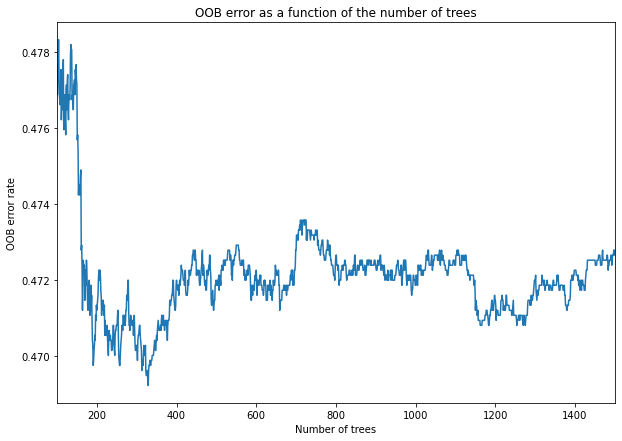

In [25]:
# Instantiate model with best hyperparameters
# We use previously computed class weights
# (setting class_weights='balanced' as an argument of the random forest instance
# is not recommended when using warm_start=True)
rf_classifier = RandomForestClassifier(criterion='gini', bootstrap=True, class_weight=weights, 
                                        warm_start=True, oob_score=True)
rf_classifier.set_params(**clf_rf.best_params_)

# Initialize arrays
xs = []
ys = []

# Range of values for the number of trees
min_estimators = 100
max_estimators = 1500

# Get OOB error for each number of trees
for i in range(min_estimators, max_estimators + 1):
    rf_classifier.set_params(n_estimators=i)
    rf_classifier.fit(X_train, y_train)
    oob_error = 1 - rf_classifier.oob_score_
    xs.append(i)
    ys.append(oob_error)

# Plot the OOB error as a function of the number of trees
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(xs, ys)
ax.set_xlim(min_estimators, max_estimators)
ax.set_xlabel("Number of trees")
ax.set_ylabel("OOB error rate")
ax.set_title('OOB error as a function of the number of trees');

### Test results

As before, let's plot the confusion matrix, get the performance metrics and plot the ROC and PR curves.

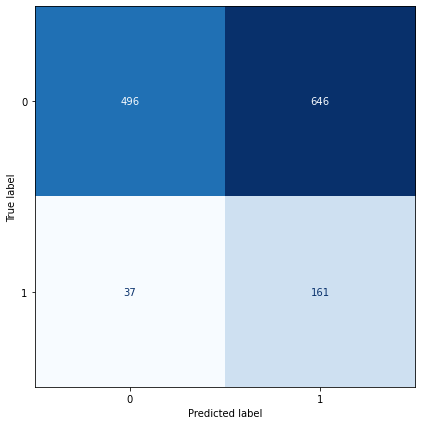

In [26]:
# Predictions on test set
clf_rf.best_estimator_.set_params(n_estimators=2000, n_jobs=-1)
y_pred = clf_rf.predict(X_test)

# Plot confusion matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm_rf =  confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=clf_rf.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=False);

In [27]:
# Get performance metrics
accuracy_rf = accuracy_score(y_test, y_pred)
recall1_rf = recall_score(y_test, y_pred)
recall0_rf = recall_score(y_test, y_pred, pos_label=0)
recall_macro_rf = recall_score(y_test, y_pred, average='macro')
precision_rf = precision_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
roc_rf = roc_auc_score(y_test, y_pred)

# Dataframe with performance metrics
df_res['RF'] = [recall1_rf, recall0_rf, recall_macro_rf, accuracy_rf, precision_rf, f1_rf, roc_rf]

df_res

,LR,RF
Recall (1),0.742424,0.813131
Recall (0),0.608581,0.434326
Recall macro,0.675503,0.623729
Accuracy,0.628358,0.490299
Precision,0.247475,0.199504
F1 score,0.371212,0.320398
ROC-AUC,0.675503,0.623729


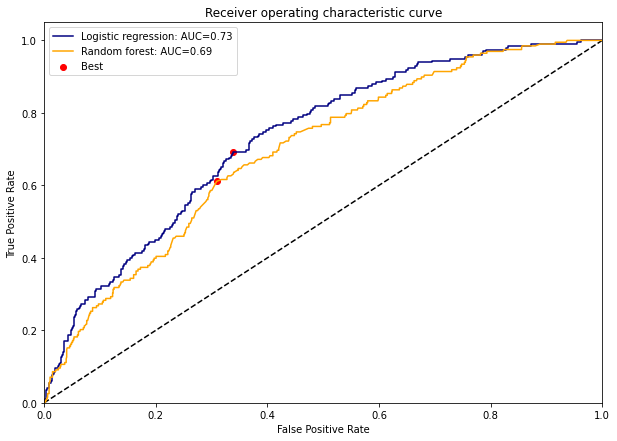

In [28]:
# Get probabilities
probs_rf = clf_rf.predict_proba(X_test)
probs_rf = probs_rf[:,1]

# Compute AUC, false positive rate and true positive rate
auc_rf = roc_auc_score(y_test, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)

# Index of best threshold
gmeans_rf = np.sqrt(tpr_rf * (1-fpr_rf))
ix = np.argmax(gmeans_rf)

# Plot the ROC curve
ax_roc.plot(fpr_rf, tpr_rf, color='orange', label='Random forest: AUC=' + str(round(auc_rf, 2)))
ax_roc.scatter(fpr_rf[ix], tpr_rf[ix], marker='o', color='red')
ax_roc.legend(loc='best')

fig_roc

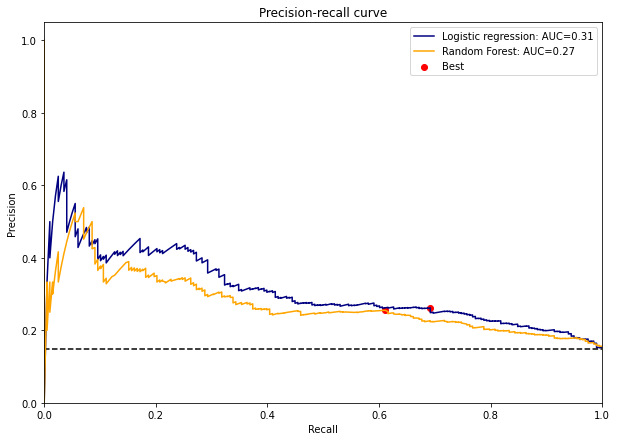

In [58]:
prec_rf, rec_rf, thresholds_pr_rf = precision_recall_curve(y_test, probs_rf)
auc_rf_pr = auc(rec_rf, prec_rf)

with np.errstate(divide='ignore', invalid='ignore'):
    fscore = (2 * prec_rf * rec_rf) / (prec_rf + rec_rf)
ix = np.nanargmax(fscore)

# Plot the PR curve
ax_pr.plot(rec_rf, prec_rf, color='orange', label='Random Forest: AUC=' + str(round(auc_rf_pr, 2)))
ax_pr.scatter(rec_rf[ix], prec_rf[ix], marker='o', color='red')
ax_pr.legend(loc='best')

fig_pr

### Feature importance

Random forest models have a built-in relative feature importance. Let's first plot it and then we will plot the permutation feature importance. 

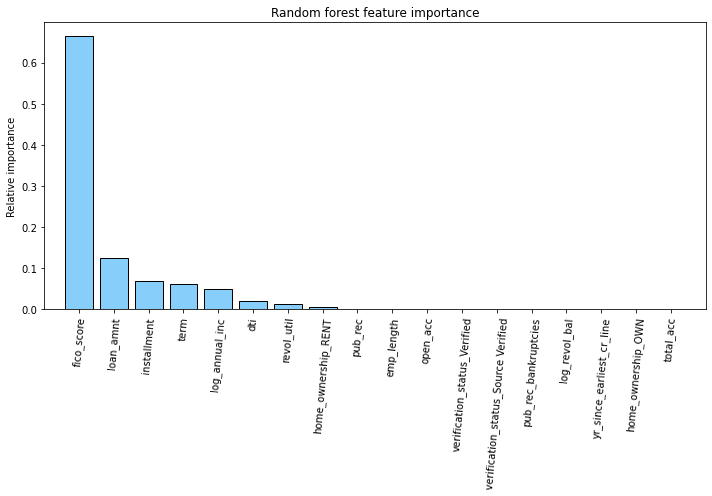

In [30]:
# Get features and coefficients from the random forest
feat_imp = clf_rf.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)[::-1]

# Plot the relative feature importance
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_title("Random forest feature importance")
ax.bar(range(X.shape[1]), feat_imp[indices], color="lightskyblue", align="center", edgecolor='k')
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(features[indices], rotation=85)
ax.set_xlim([-1, X.shape[1]])
ax.set_ylabel('Relative importance')
plt.tight_layout()

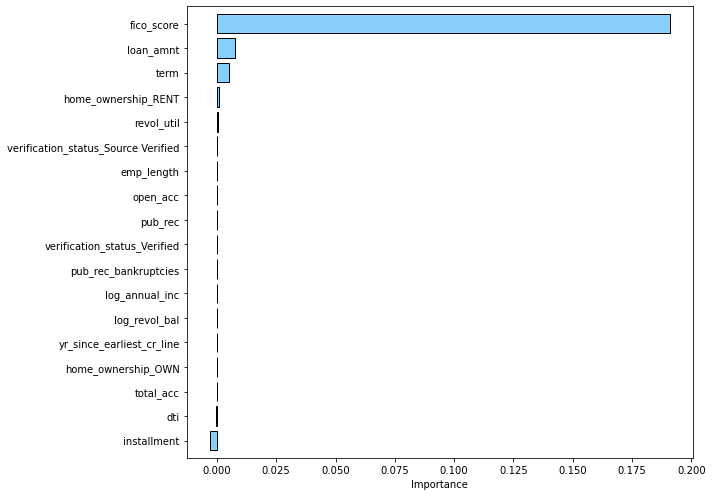

In [31]:
# Permutation feature importance
perm_imp = permutation_importance(clf_rf, X_test, y_test, n_repeats=10, scoring='recall')

# Get index order
sorted_idx = perm_imp.importances_mean.argsort()

# Plot permutation feature importance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.barh(range(len(sorted_idx)), perm_imp.importances_mean[sorted_idx], color="lightskyblue", 
        align='center', ec='k')
ax.set_ylim(-0.7, len(sorted_idx)-0.3)
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance');
plt.tight_layout()

## Gradient boosting

### Hyperparameter tuning

Now we implement a gradient boosting model. Given the high number of hyperparameters, we use a Bayesian hyperparameter optimization method: Tree Parzen Estimator (TPE). First, we need to define an objective function (to be minimized) and the hyperparameter space. Then, we retrieve the best hyperparameters using ```fmin``` from the ```HyperOpt``` package. The optimization metric is the macro recall. We use 50 iterations to find the best parameters. This number is rather small but we try to limit the computation time. Increasing the number of iterations would likely lead to a better optimization result.

In [32]:
# define objective function
def objective(params):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    clf_xgb = XGBClassifier(scale_pos_weight=(neg/pos), eval_metric="error", use_label_encoder=False, **params)
    
    score = cross_val_score(clf_xgb, X_train, y_train, cv=n_folds, scoring='recall')
    score = np.mean(score)
    
    # Loss must be minimized
    loss = 1 - score
    
    return loss

# Define hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1500, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth' : hp.quniform('max_depth', 4, 10, 1),
    'subsample' : hp.uniform('subsample', 0.5, 1.0),
    'alpha' : hp.uniform('alpha', 0.0, 150.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 150.0),
#    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.0, 1.0)
}

# To analyze the trials
trials = Trials()

# Get best hyperparameters
best_params_gb = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print('\n')
print('Best hyperparameters are :')
print(best_params_gb)

100%|█████████| 50/50 [04:51<00:00,  5.83s/trial, best loss: 0.3509007936507935]


Best hyperparameters are :
{'alpha': 121.24808921148767, 'colsample_bynode': 0.4453335320225118, 'learning_rate': 0.07630953658571957, 'max_depth': 7.0, 'n_estimators': 1315.0, 'reg_lambda': 123.39612764389494, 'subsample': 0.8413377029080753}


Now let's fit a model with those hyperparameters.

In [33]:
# Convert floats to integers when needed
best_params_gb['n_estimators'] = int(best_params_gb['n_estimators'])
best_params_gb['max_depth'] = int(best_params_gb['max_depth'])

# Instantiate and fit the model
clf_gb = XGBClassifier(scale_pos_weight=(neg/pos), eval_metric="error", use_label_encoder=False, **best_params_gb)
clf_gb.fit(X_train, y_train);

### Test results

As for the other models, we now show the confusion matrix and performance metrics as well as the ROC and PR curves.

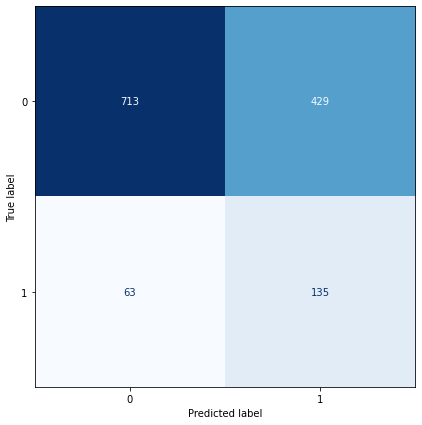

In [34]:
y_pred = clf_gb.predict(X_test)

# Plot confusion matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm_gb =  confusion_matrix(y_test, y_pred, labels=clf_gb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=clf_gb.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=False);

In [35]:
# Get performance metrics
accuracy_gb = accuracy_score(y_test, y_pred)
recall1_gb = recall_score(y_test, y_pred)
recall0_gb = recall_score(y_test, y_pred, pos_label=0)
recall_macro_gb = recall_score(y_test, y_pred, average='macro')
precision_gb = precision_score(y_test, y_pred)
f1_gb = f1_score(y_test, y_pred)
roc_gb = roc_auc_score(y_test, y_pred)

# Dataframe with performance metrics
df_res['GB'] = [recall1_gb, recall0_gb, recall_macro_gb, accuracy_gb, precision_gb, f1_gb, roc_gb]

df_res

,LR,RF,GB
Recall (1),0.742424,0.813131,0.681818
Recall (0),0.608581,0.434326,0.624343
Recall macro,0.675503,0.623729,0.653081
Accuracy,0.628358,0.490299,0.632836
Precision,0.247475,0.199504,0.239362
F1 score,0.371212,0.320398,0.354331
ROC-AUC,0.675503,0.623729,0.653081


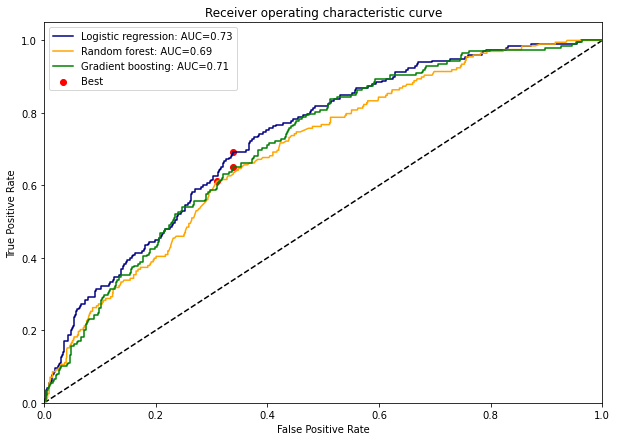

In [36]:
# Get probabilities
probs_gb = clf_gb.predict_proba(X_test)
probs_gb = probs_gb[:,1]

# Compute AUC, false positive rate and true positive rate
auc_gb = roc_auc_score(y_test, probs_gb)
fpr_gb, tpr_gb, _ = roc_curve(y_test, probs_gb)

# Index of best threshold
gmeans_gb = np.sqrt(tpr_gb * (1-fpr_gb))
ix = np.argmax(gmeans_gb)

# Plot the ROC curve
ax_roc.plot(fpr_gb, tpr_gb, color='green', label='Gradient boosting: AUC=' + str(round(auc_gb, 2)))
ax_roc.scatter(fpr_gb[ix], tpr_gb[ix], marker='o', color='red')
ax_roc.legend(loc='best')

fig_roc

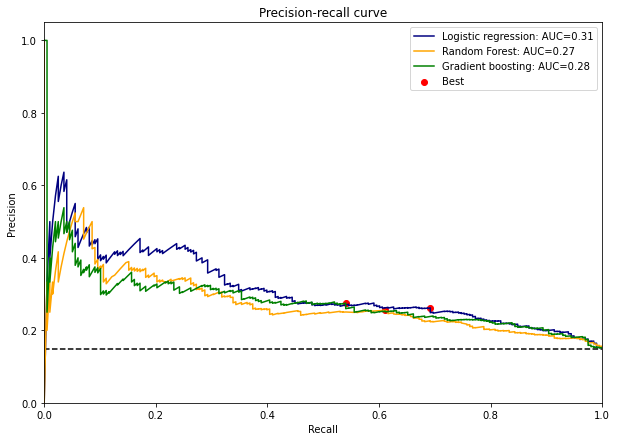

In [59]:
# PR curve
prec_gb, rec_gb, thresholds_pr_gb = precision_recall_curve(y_test, probs_gb)
auc_gb_pr = auc(rec_gb, prec_gb)

# F-score and index of best threshold
with np.errstate(divide='ignore', invalid='ignore'):
    fscore = (2 * prec_gb * rec_gb) / (prec_gb + rec_gb)
ix = np.nanargmax(fscore)

# Plot the PR curve
ax_pr.plot(rec_gb, prec_gb, color='green', label='Gradient boosting: AUC=' + str(round(auc_gb_pr, 2)))
ax_pr.scatter(rec_gb[ix], prec_gb[ix], marker='o', color='red')
ax_pr.legend(loc='best')

fig_pr

### Feature importance

Like random forests, gradient boosting models have a built-in relative feature importance. Let's plot it along with the permutation feature importance. 

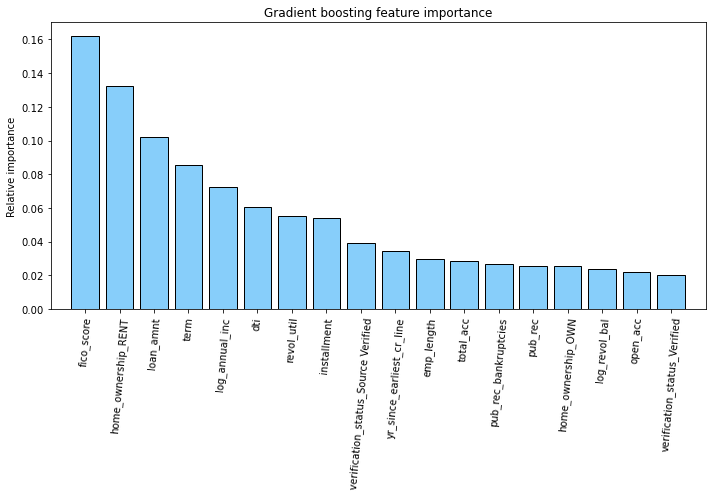

In [38]:
# Get features and coefficients from the gradient boosting
feat_imp = clf_gb.feature_importances_
indices = np.argsort(feat_imp)[::-1]

# Plot the relative feature importance
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_title("Gradient boosting feature importance")
ax.bar(range(X.shape[1]), feat_imp[indices], color="lightskyblue", align="center", edgecolor='k')
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(features[indices], rotation=85)
ax.set_xlim([-1, X.shape[1]])
ax.set_ylabel('Relative importance')
plt.tight_layout()

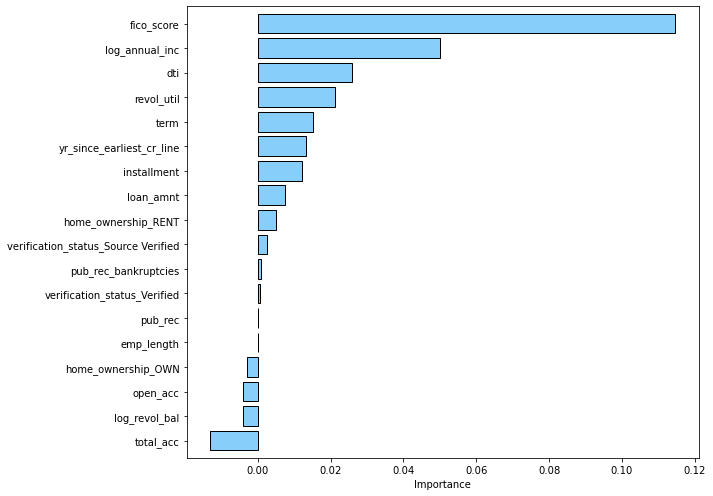

In [39]:
# Permutation feature importance
perm_imp = permutation_importance(clf_gb, X_test, y_test, n_repeats=10, scoring='recall')

# Get index order
sorted_idx = perm_imp.importances_mean.argsort()

# Plot permutation feature importance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.barh(range(len(sorted_idx)), perm_imp.importances_mean[sorted_idx], color="lightskyblue", 
        align='center', ec='k')
ax.set_ylim(-0.7, len(sorted_idx)-0.3)
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance');
plt.tight_layout()

## Artificial neural network

### Hyperparameter tuning

First let's define a function that creates our model. 

In [40]:
def ann_model(n_layers=1, units=5, activation='relu', reg_l2=0.01, reg_l1=0.00, 
              dropout=0.1, learning_rate=0.001):
    
    # Instantiate model
    ann = tf.keras.models.Sequential()
    
    # Hidden layers
    for i in range(n_layers):
        ann.add(tf.keras.layers.Dense(units=units, activation=activation, 
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(l1=reg_l1, l2=reg_l2)))
#        ann.add(tf.keras.layers.BatchNormalization())
        ann.add(tf.keras.layers.Dropout(dropout))
    
    # Output layer
    initial_bias = np.log([pos/neg])
    ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid', 
                                  bias_initializer=tf.keras.initializers.Constant(initial_bias)))
    
    # Compile model
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='binary_crossentropy', metrics=['Recall'])
    
    return ann

Neural networks also have many hyperparameters that can be tuned. Therefore, we also use Bayesian optimization for hyperparameter optimization. Because it is very long (in terms of computational time) to properly perform this step, we will only perform 10 iterations for illustrative purpose. Note that other hyperparameters could be added to the hyperparameter space below (batch size, epochs, initialization weights...). Then, instead of using those hyperparameters, we will use the default architecture of the model (in the function above). This is a network architecture that I have already tested with cross-validation and that should perform relatively well (even though it can be improved).

In [41]:
# Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=10, 
                                                  mode='auto', restore_best_weights=True)


# Objective function (to be minimized)
def objective(params):
    
    if 'n_layers' in params.keys():
        params['n_layers'] = int(params['n_layers'])
    
    clf_ann = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, 
                                                             epochs=100, batch_size=32, **params)
    
    score = cross_val_score(clf_ann, X_train, y_train, cv=n_folds, scoring='recall_macro',
                            fit_params = {'callbacks': [early_stopping], 'class_weight': class_weight, 
                                          'verbose': 0})
    score = np.mean(score)
    
    # Loss must be minimized
    loss = 1 - score
    
    return loss

# input for activation function choice
activation_choice = ['tanh', 'relu']

# Hyperparameter space
space = {
    'activation': hp.choice('activation', activation_choice),
    'reg_l1': hp.loguniform('reg_l1', np.log(0.001), np.log(1.0)),
    'reg_l2': hp.loguniform('reg_l2', np.log(0.001), np.log(1.0)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'units': hp.quniform('units', 3, 8, 1),
    'n_layers': hp.quniform('n_layers', 1, 2, 1),
    'dropout': hp.uniform('dropout', 0.0, 0.5)
}

# To analyze the trials
trials = Trials()

# Get best hyperparameters
best_params_ann = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Convert hyperparameters when needed
best_params_ann['activation'] = activation_choice[best_params_ann['activation']]
best_params_ann['n_layers'] = int(best_params_ann['n_layers'])

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

2021-11-03 18:05:24.340890: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 18:05:24.341130: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


100%|█████████| 10/10 [08:12<00:00, 49.26s/trial, best loss: 0.3638086725207098]


In [42]:
print('Best hyperparameters are :')
print(best_params_ann)



Best hyperparameters are :
{'activation': 'relu', 'dropout': 0.06057159084539149, 'learning_rate': 0.017831022733561228, 'n_layers': 1, 'reg_l1': 0.001520467190146165, 'reg_l2': 0.0021088806415650685, 'units': 4.0}


### Test results

Let's fit the model and plot the usual results.

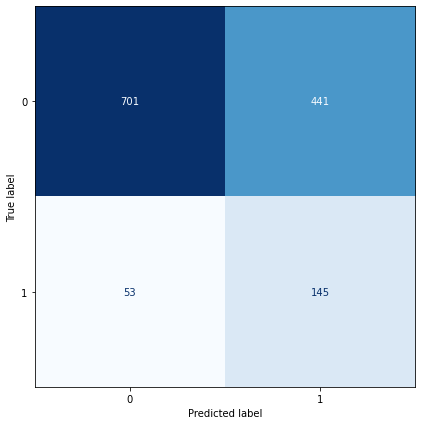

In [43]:
# Create model
#clf_ann = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, 
#                                                         epochs=100, batch_size=32, **params)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=10, 
                                                  mode='auto', restore_best_weights=True)

clf_ann = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, epochs=100, batch_size=32)

# Fit model
clf_ann.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[early_stopping],
            class_weight=class_weight, verbose=0)

# Predictions
probs_ann = clf_ann.predict_proba(X_test)[:,1]
y_pred = (probs_ann > 0.5).astype(int)

# Plot confusion matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm_ann =  confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=[0,1])
disp.plot(cmap='Blues', ax=ax, colorbar=False);

In [44]:
# Get performance metrics
accuracy_ann = accuracy_score(y_test, y_pred)
recall1_ann = recall_score(y_test, y_pred)
recall0_ann = recall_score(y_test, y_pred, pos_label=0)
recall_macro_ann = recall_score(y_test, y_pred, average='macro')
precision_ann = precision_score(y_test, y_pred)
f1_ann = f1_score(y_test, y_pred)
roc_ann = roc_auc_score(y_test, y_pred)

# Dataframe with performance metrics
df_res['ANN'] = [recall1_ann, recall0_ann, recall_macro_ann, accuracy_ann, precision_ann, f1_ann, roc_ann]

df_res

,LR,RF,GB,ANN
Recall (1),0.742424,0.813131,0.681818,0.732323
Recall (0),0.608581,0.434326,0.624343,0.613835
Recall macro,0.675503,0.623729,0.653081,0.673079
Accuracy,0.628358,0.490299,0.632836,0.631343
Precision,0.247475,0.199504,0.239362,0.247440
F1 score,0.371212,0.320398,0.354331,0.369898
ROC-AUC,0.675503,0.623729,0.653081,0.673079


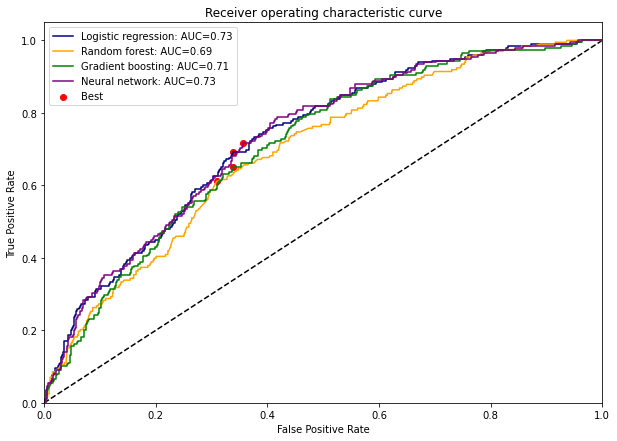

In [45]:
# Compute AUC, false positive rate and true positive rate
auc_ann = roc_auc_score(y_test, probs_ann)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, probs_ann)

# Index of best threshold
gmeans_ann = np.sqrt(tpr_ann * (1-fpr_ann))
ix = np.argmax(gmeans_ann)

# Plot the ROC curve
ax_roc.plot(fpr_ann, tpr_ann, color='purple', label='Neural network: AUC=' + str(round(auc_ann, 2)))
ax_roc.scatter(fpr_ann[ix], tpr_ann[ix], marker='o', color='red')
ax_roc.legend(loc='best')

fig_roc

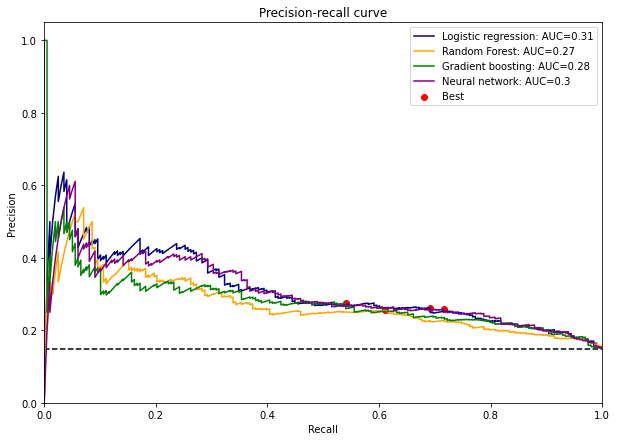

In [60]:
# PR curve
prec_ann, rec_ann, thresholds_pr_ann = precision_recall_curve(y_test, probs_ann)
auc_ann_pr = auc(rec_ann, prec_ann)

# F1-score and index of best threshold
with np.errstate(divide='ignore', invalid='ignore'):
    fscore = (2 * prec_ann * rec_ann) / (prec_ann + rec_ann)
ix = np.nanargmax(fscore)

# Plot the PR curve
ax_pr.plot(rec_ann, prec_ann, color='purple', label='Neural network: AUC=' + str(round(auc_ann_pr, 2)))
ax_pr.scatter(rec_ann[ix], prec_ann[ix], marker='o', color='red')
ax_pr.legend(loc='best')

fig_pr

### Feature importance

Let's plot the permutation feature importance.

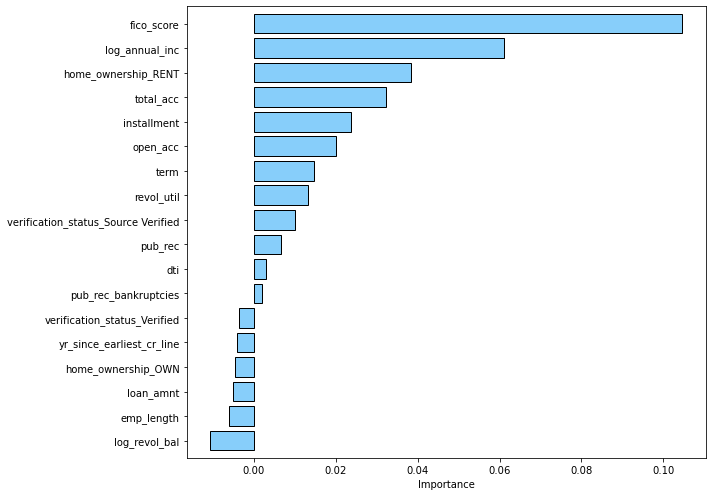

In [47]:
# Permutation feature importance
perm_imp = permutation_importance(clf_ann, X_test, y_test, n_repeats=10, scoring='recall')

# Get index order
sorted_idx = perm_imp.importances_mean.argsort()

# Plot permutation feature importance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.barh(range(len(sorted_idx)), perm_imp.importances_mean[sorted_idx], color="lightskyblue", 
        align='center', ec='k')
ax.set_ylim(-0.7, len(sorted_idx)-0.3)
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance');
plt.tight_layout()

## Stacking

Finally, we use a stacking approach. The four models above are used as the base models (1st level) and a random forest classifier is used as the meta model (2nd level). First, we compute the out-of-fold (OOF) predictions for all the models. We implement the stacking algorithm from scratch as the standard implementations (e.g., from ```Scikit-learn``` or ```vecstack```) do not allow (to our knowledge) to use the class weights argument in the fit method (needed for our neural network). 

First, let's get the OOF predictions from the three first models (i.e., LR, RF, GB).

In [48]:
# 1st level model
models = [clf_lr.best_estimator_, clf_rf.best_estimator_, clf_gb]

# Empty array to store single model out-of-fold predictions
S_train_temp = np.zeros((X_train.shape[0], 1))

# Empty array to stock OOF predictions for all the models
S_train = np.zeros((X_train.shape[0], len(models)))

# Empty array to store temporary test set predictions made in each fold
S_test_temp = np.zeros((X_test.shape[0], n_folds))

# Empty array to stock OOF predictions for all the models
S_test = np.zeros((X_test.shape[0], len(models)))

# Loop across models
for i, model in enumerate(models):
    # Loop across folds
    for j, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):

        # Split data and target
        X_tr = X_train[train_idx]
        y_tr = y_train[train_idx]
        X_te = X_train[test_idx]
        y_te = y_train[test_idx]

        # Fit
        _ = model.fit(X_tr, y_tr)

        # Predict out-of-fold part of train set
        S_train_temp[test_idx, :] = model.predict_proba(X_te)[:,1].reshape(-1, 1)

        # Predict test set
        S_test_temp[:, j] = model.predict_proba(X_test)[:,1]
    
    # Add OOF predictions for current model to the final training set
    S_train[:, i] = S_train_temp.reshape((-1, ))
    
    # Compute mean of temporary test set predictions to get final test set prediction
    S_test[:, i] = np.mean(S_test_temp, axis=1).reshape((-1, ))

Now, let's get the OOF predictions from the neural network.

In [49]:
# Empty array to store single model out-of-fold predictions
S_train_ann = np.zeros((X_train.shape[0], 1))

# Empty array to store temporary test set predictions made in each fold
S_test_temp = np.zeros((X_test.shape[0], n_folds))

# Empty array to stock OOF predictions for all the models
S_test_ann = np.zeros((X_test.shape[0], 1))

for j, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):

    # Split data and target
    X_tr = X_train[train_idx]
    y_tr = y_train[train_idx]
    X_te = X_train[test_idx]
    y_te = y_train[test_idx]

    # Fit
    _ = clf_ann.fit(X_tr, y_tr, batch_size=32, epochs=100, class_weight=class_weight, 
                    callbacks=[early_stopping], verbose=0)

    # Predict out-of-fold part of train set
    S_train_ann[test_idx, :] = clf_ann.predict_proba(X_te)[:,1].reshape(-1, 1)

    # Predict test set
    S_test_temp[:, j] = clf_ann.predict_proba(X_test)[:,1]

# Compute mean of temporary test set predictions to get final test set prediction
S_test_ann = np.mean(S_test_temp, axis=1).reshape((-1,1))

Let's create our training and test sets with all the OOF predictions.

In [50]:
S_train = np.hstack((S_train, S_train_ann))
S_test = np.hstack((S_test, S_test_ann))

Stacking performs particularly well when the base models provide predictions that are not too correlated. Let's check the correlation matrix.

In [51]:
np.corrcoef(S_train, rowvar=False)

array([[1.        , 0.75471414, 0.91206032, 0.98148716],
       [0.75471414, 1.        , 0.77740771, 0.72975516],
       [0.91206032, 0.77740771, 1.        , 0.90412586],
       [0.98148716, 0.72975516, 0.90412586, 1.        ]])

The pairwise correlation coefficients are relatively high. We could reduce them by modifying the models (use different optimization metrics for some models, use different subset of features for some models, add more regularization to some models...).

### Test results

Let's plot the usual results.

In [52]:
# Instantiate model
rfc = RandomForestClassifier(criterion='gini', n_estimators=100, bootstrap=True,
                             class_weight='balanced_subsample')

# Grid for grid search
param_grid = {'max_depth' : [2, 3, 4, 5], 
              'max_features' : [1, 2, 3, 4],
              }

# Instantiate grid search
clf_meta = GridSearchCV(rfc, param_grid, scoring='recall_macro', cv=n_folds, n_jobs=-1)

# Fit model
clf_meta.fit(S_train, y_train)

# Print best hyperparameters from grid search
print('Best hyperparameters are :')
clf_meta.best_params_

Best hyperparameters are :


{'max_depth': 3, 'max_features': 4}

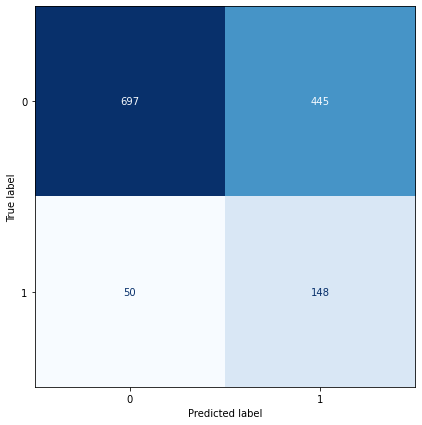

In [53]:
y_pred = clf_meta.predict(S_test)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm_ann =  confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=[0,1])
disp.plot(cmap='Blues', ax=ax, colorbar=False);

In [54]:
# Get performance metrics
accuracy_sc = accuracy_score(y_test, y_pred)
recall1_sc = recall_score(y_test, y_pred)
recall0_sc = recall_score(y_test, y_pred, pos_label=0)
recall_macro_sc = recall_score(y_test, y_pred, average='macro')
precision_sc = precision_score(y_test, y_pred)
f1_sc = f1_score(y_test, y_pred)
roc_sc = roc_auc_score(y_test, y_pred)

# Dataframe with performance metrics
df_res['SC'] = [recall1_sc, recall0_sc, recall_macro_sc, accuracy_sc, precision_sc, f1_sc, roc_sc]

df_res

,LR,RF,GB,ANN,SC
Recall (1),0.742424,0.813131,0.681818,0.732323,0.747475
Recall (0),0.608581,0.434326,0.624343,0.613835,0.610333
Recall macro,0.675503,0.623729,0.653081,0.673079,0.678904
Accuracy,0.628358,0.490299,0.632836,0.631343,0.630597
Precision,0.247475,0.199504,0.239362,0.247440,0.249578
F1 score,0.371212,0.320398,0.354331,0.369898,0.374210
ROC-AUC,0.675503,0.623729,0.653081,0.673079,0.678904


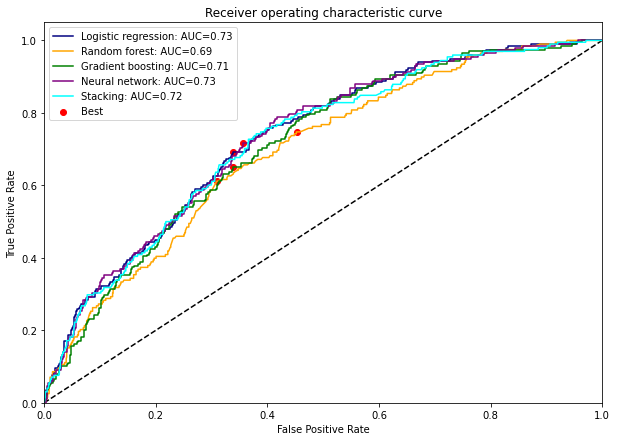

In [55]:
# Get probabilities
probs_sc = clf_meta.predict_proba(S_test)
probs_sc = probs_sc[:,1]

# Compute AUC, false positive rate and true positive rate
auc_sc = roc_auc_score(y_test, probs_sc)
fpr_sc, tpr_sc, thresholds_rf = roc_curve(y_test, probs_sc)

# Index of best threshold
gmeans_sc = np.sqrt(tpr_sc * (1-fpr_sc))
ix = np.argmax(gmeans_sc)

# Plot the ROC curve
ax_roc.plot(fpr_sc, tpr_sc, color='cyan', label='Stacking: AUC=' + str(round(auc_sc, 2)))
ax_roc.scatter(fpr_rf[ix], tpr_rf[ix], marker='o', color='red')
ax_roc.legend(loc='best')

fig_roc

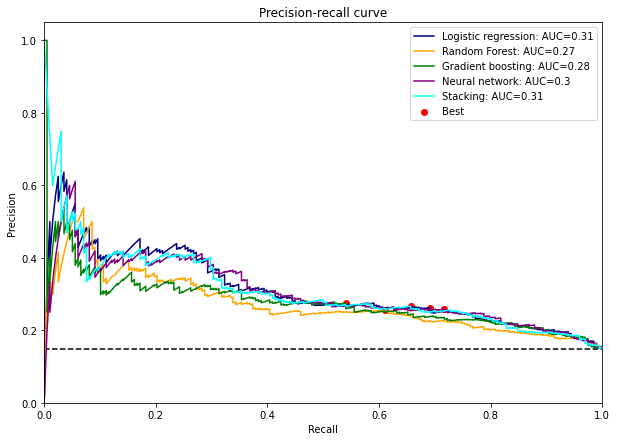

In [61]:
prec_sc, rec_sc, thresholds_pr_sc = precision_recall_curve(y_test, probs_sc)
auc_sc_pr = auc(rec_sc, prec_sc)

with np.errstate(divide='ignore', invalid='ignore'):
    fscore = (2 * prec_sc * rec_sc) / (prec_sc + rec_sc)
ix = np.nanargmax(fscore)

# Plot the PR curve
ax_pr.plot(rec_sc, prec_sc, color='cyan', label='Stacking: AUC=' + str(round(auc_sc_pr, 2)))
ax_pr.scatter(rec_sc[ix], prec_sc[ix], marker='o', color='red')
ax_pr.legend(loc='best')

fig_pr

## Conclusion

On out-of-sample observations, the random forest model has the highest recall for the positive class. This was expected as it is the only model that is optimized with this metric. However, the high recall (for the positive class) comes at the expense of a low recall for the negative class.

The stacked model seems to offer the best performance with a relatively high recall for the positive class and the highest macro recall. This model seems to be the best choice for the bank to identify defaulting loans without misclassifying too many non-defaulting loans. However, this model is the most computationally expensive.

With all the models, the FICO score is the most important feature. This makes sense as this score evaluates creditworthiness. The second feature with most explanatory power is the annual income. This is also intuitive. Some other features have very low explanatory power. An example is the ```log_revol_bal``` feature. Indeed, shuffling this feature improves the score for several models. We should note that some features are highly correlated. Therefore, the feature importance measures are biased for those features. It would have been judicious to remove some of the highly correlated features before fitting the models.